# 1. Business Objective

The objective is to conduct an AB test. The context is that: 

**Cookie Cats** is a  popular mobile puzzle game developed by **Tactile Entertainment**. Think Candy Crush with cookies and cats.

<p>As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully this increases the player's enjoyment of the game and keeps them playing for a longer period.</p>


<p>The first gate is initially placed at level 30 but the developers want to test the impact of moving the gate to level 40. In particular, the impact on player retention. 

In this Notebook I provide a solution which performs an AB test based on bootstrapping to evaluate the impact of the two gate variants on player retention. Pandas, matplotlib and scipy libraries are used in this solution.

In [74]:
# Importing pandas, matplotlib and scipy
import pandas as pd
import matplotlib
import scipy


In [75]:
# Setting up for data import.
import os 
os.chdir(r'C:\Users\shobh\Documents\ab testing')

In [76]:
# Importing the data.
df = pd.read_csv('cookie_cats.csv')

# 2. Overview of dataset

<p>The data is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code>- whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>

Note that the data is tidy and ready for analysis.

In [77]:
# An overview of data with the first few rows. 
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


# 3. Data quality and distribution
When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. We start by checking if there were roughly the same number of players in each group. 

In [78]:
# Counting the number of players in each AB group.
players_g30 = df[df['version'] == 'gate_30']
players_g40 = df[df['version'] == 'gate_40']

print('Number of players tested at Gate 30:', str(players_g30.shape[0]), '\n',
     'Number of players tested at Gate 40:', str(players_g40.shape[0]))

Number of players tested at Gate 30: 44700 
 Number of players tested at Gate 40: 45489


Looks like there are roughly the same number of players in each group so the data is good for AB testing.

We will now plot the distribution of the number of users who played 0 to 100 game rounds to get an idea of general player behaviour. 

Text(0.5, 1.0, 'Distribution of number of users and rounds')

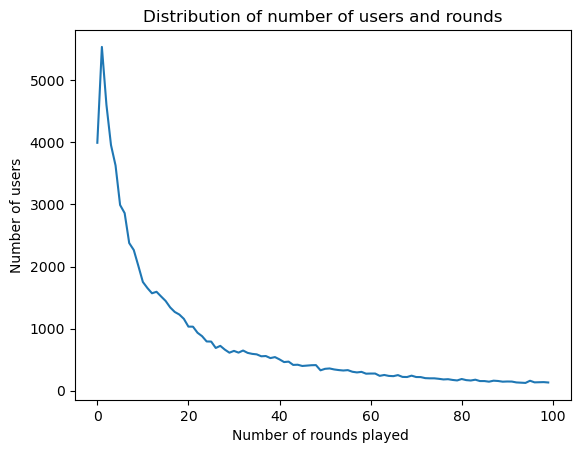

In [79]:
# This command makes plots appear in the notebook
%matplotlib inline

# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(n=100).plot(x="sum_gamerounds", y="userid")
ax.set_xlabel("Number of rounds played ")
ax.set_ylabel("Number of users")
ax.set_title("Distribution of number of users and rounds")

The plot shows an expected trend some players install the game but then never play it (0  rounds), some players just play a couple of rounds while a few get hooked and play a lot of rounds.

# 4. 1-day retention

1- day retention is a common metric used in the video gaming industry to evaluate  how engaging a game is. It measures the percentage of players that play the game one day after they have installed it. High 1-day retention rates imply that it is easier to retain players and build a large player base. 
Let's look at overall 1-day retention for cookie cats.


In [80]:
# Overall 1-day retention rate.
r1o= (df['retention_1'].sum() / df['retention_1'].count())*100
print("Overall 1-day retention is: ", str(round(r1o,2)),"%")

Overall 1-day retention is:  44.52 %


This retention rate of 44.52% provides a benchmark and can be used to evaluate the difference in 1-day retention between the two AB groups. 

# 5. 1-day retention between AB groups 

In [81]:
#Computing the 1-day retention rate for each group. 
# CONTROL GROUP
prop_gate30 = len(players_g30[players_g30['retention_1'] == True])/len(players_g30['retention_1']) * 100

# TREATMENT GROUP
prop_gate40 = len(players_g40[players_g40['retention_1'] == True])/len(players_g40['retention_1']) * 100

print('Group 30 1-day retention: ',str(round(prop_gate30,2)),"%","\n","Group 40 1-day retention:",str(round(prop_gate40,2)),"%")

Group 30 1-day retention:  44.82 % 
 Group 40 1-day retention: 44.23 %


# 6. Bootstrapping


It seems that shifting the gate to level 40 (44.2%) resulted in a minor drop in 1-day retention compared to the control when the gate was at level 30 (44.8%). Although the change is small, it can have a significant impact on retention. However, even though we have observed a difference in the data, we are uncertain about whether a gate at level 40 will continue to perform worse in the future because there could be sampling errors.

To determine the certainty of these retention figures, we can use bootstrapping. By repeatedly resampling the dataset (with replacements allowed) and computing 1-day retention for each sample, we can gauge the variability in 1-day retention and assess the uncertainty of the retention figures

Note: I am bootstrapping for mean retention rate. I have also restricted the number of bootstrap replications to 500 for the sake of quicker calculations. However, in a "production" setting, it's advisable to increase the number of replications significantly, perhaps to as many as 10,000.

<Axes: ylabel='Density'>

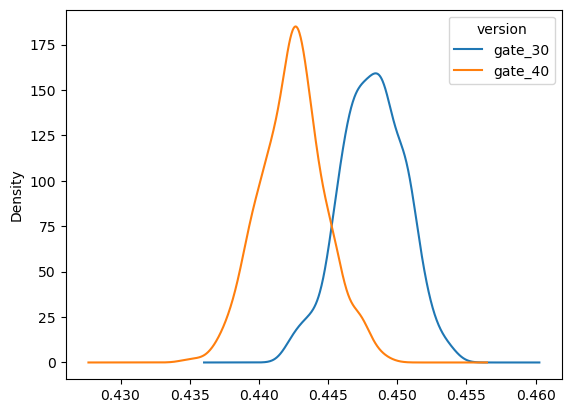

In [82]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='kde')

The graphs above show how unsure we are about the actual 1-day retention rates of the two AB-groups, based on the process of bootstrapping. By looking at the graphs, we can tell that there might be a slight difference in the mean retention rates between the two groups. But the difference is so small that it is preferable to zoom in on it by plotting the difference itself as an individual measure.


Text(0.5, 0, '% difference in means')

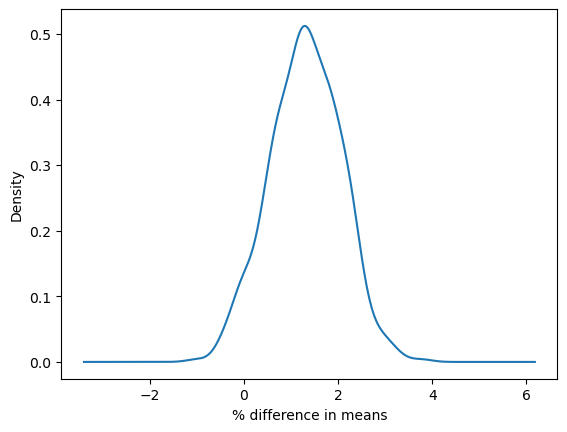

In [83]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) /  boot_1d['gate_40'] * 100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

# 7. The probability of a difference
Looking at the chart, it is evident that the percentage difference is approximately 1% - 2%, and the majority of the distribution is in favor of a gate at level 30, with most values above 0%. 

I will now compute the probability of the difference being greater than 0%.

In [84]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff'] > 0.0).sum() / len(boot_1d['diff'])

# Pretty printing the probability
print('The probabilty of Group 30 (Control) having a higher \nretention than Group 40 (Treatment) is: ', prob*100, '%')


The probabilty of Group 30 (Control) having a higher 
retention than Group 40 (Treatment) is:  94.19999999999999 %


# 8. 7-day retention between AB groups 
According to the bootstrap analysis, it is highly probable that 1-day retention is improved when the time gate is set at level 30. However, since the game has only been played for a day, it's likely that most players haven't yet attained level 30, indicating that a significant portion of players may not be affected by the gate at such an early stage.

Therefore, it is important to consider 7-day retention as well, as more players are expected to have achieved level 40 after a week of gameplay.

In [85]:
# Calculating 7-day retention for both AB-groups
ret30_7d = len(players_g30[players_g30['retention_7'] == True])/len(players_g30['retention_7']) * 100
ret40_7d = len(players_g40[players_g40['retention_7'] == True])/len(players_g40['retention_7']) * 100

print('Group 30 at 7 day retention: ',str(round(ret30_7d,2)),"%","\n",
     'Group 40 at 7 day retention: ',str(round(ret40_7d,2)),"%")

Group 30 at 7 day retention:  19.02 % 
 Group 40 at 7 day retention:  18.2 %


# 9. Bootstrapping again

Similar to 1-day retention, the data indicates that when the gate is placed at level 40, the 7-day retention is slightly reduced (18.2%) compared to when the gate is at level 30 (19.0%). This difference is larger than that of 1-day retention, which could be attributed to more players having had adequate time to encounter the first gate. It's also noticeable that the overall 7-day retention rate is lower than the overall 1-day retention rate, implying that fewer individuals play the game a week after installation than a day after installation.

Nonetheless, as previously mentioned, we can utilize bootstrap analysis to determine the level of certainty regarding the difference between the AB groups.

The probabilty of Group 30 (Control) having a higher 
 retention than Group 40 (Treatment) is: ~ 100.0 %


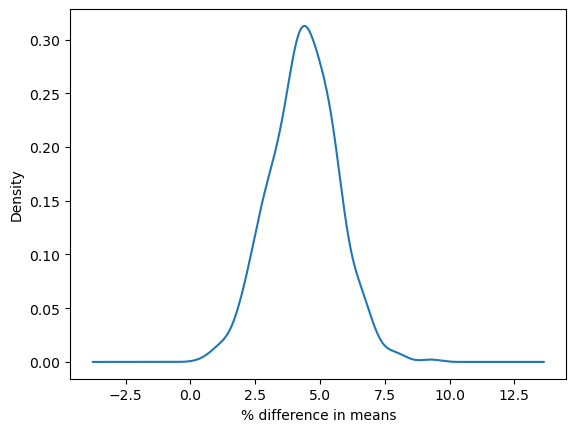

In [86]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) /  boot_7d['gate_30'] * 100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d)

# Pretty printing the probability
print('The probabilty of Group 30 (Control) having a higher \n retention than Group 40 (Treatment) is: ~', prob*100, '%')

# 10. Conclusion 

The bootstrap outcome shows that 7-day retention is superior when the gate is set at level 30, implying that moving the gate to level 40 would negatively impact both 1-day and 7-day retention. Therefore, it is recommended that the gate is kept at level 30. 